# General Instructions to students:

1. There are 5 types of cells in this notebook. The cell type will be indicated within the cell.
    1. Markdown cells with problem written in it. (DO NOT TOUCH THESE CELLS) (**Cell type: TextRead**)
    2. Python cells with setup code for further evaluations. (DO NOT TOUCH THESE CELLS) (**Cell type: CodeRead**)
    3. Python code cells with some template code or empty cell. (FILL CODE IN THESE CELLS BASED ON INSTRUCTIONS IN CURRENT AND PREVIOUS CELLS) (**Cell type: CodeWrite**)
    4. Markdown cells where a written reasoning or conclusion is expected. (WRITE SENTENCES IN THESE CELLS) (**Cell type: TextWrite**)
    5. Temporary code cells for convenience and TAs. (YOU MAY DO WHAT YOU WILL WITH THESE CELLS, TAs WILL REPLACE WHATEVER YOU WRITE HERE WITH OFFICIAL EVALUATION CODE) (**Cell type: Convenience**)
    
2. You are not allowed to insert new cells in the submitted notebook.

3. You are not allowed to import any extra packages.

4. The code is to be written in Python 3.6 syntax. Latest versions of other packages maybe assumed.

5. In CodeWrite Cells, the only outputs to be given are plots asked in the question. Nothing else to be output/print. 

6. If TextWrite cells ask you to give accuracy/error/other numbers you can print them on the code cells, but remove the print statements before submitting.

7. The convenience code can be used to check the expected syntax of the functions. At a minimum, your entire notebook must run with "run all" with the convenience cells as it is. Any runtime failures on the submitted notebook as it is will get zero marks.

8. All code must be written by yourself. Copying from other students/material on the web is strictly prohibited. Any violations will result in zero marks.

9. All datasets will be given as .npz files, and will contain data in 4 numpy arrays :"X_train, Y_train, X_test, Y_test". In that order. The meaning of the 4 arrays can be easily inferred from their names.

10. All plots must be labelled properly, all tables must have rows and columns named properly.

11. Before subbmission ensure that you submit with the outputs (do not clear the outputs), so that when evaluating we can run selectively.

12. Before submission ensure that the path for the folder containing the data is "../../Data/" 


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import matplotlib as mpl
import pandas as pd

# 1. Logistic Regression 

Write code for doing logistic regression below. Also write code for choosing best hyperparameters for each kernel type (use a part of training set as validation set). 

The range of hyperparameters is typically chosen on a log scale e.g. 1e-4, 1e-3, 1e-2... 1e3.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters. 

For each given hyperparameter setting (kernel and regularisation) you will have to do some exploring to find the right learning rate to use in gradient descent. The optimisation learning rate is not a model hyperparameter and hence can be chosen based on just the training set. i.e. choose the learning rate for which the training loss decreases the most.

For the synthetic classification datasets (dataset_A and dataset_B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.


In [10]:
# CodeWrite 
#Write logistic regression code from scratch. Use gradient descent.
# Only write functions here
def read(filename):
    data = np.load('../../Data/'+filename)
    lst = data.files
    
    X_train = data[lst[0]]
    Y_train = data[lst[1]]
    X_test  = data[lst[2]]
    Y_test  = data[lst[3]]
    
    return X_train, Y_train, X_test, Y_test


def separate(X,Y):
    X_g_y_m1 = [] #shall contain X for which Y = -1
    X_g_y_p1 = [] #shall contain X for which Y = +1
    
    for i in range(Y.shape[0]):
        if(Y[i]==-1):
            X_g_y_m1.append(X[i])
        else:
            X_g_y_p1.append(X[i])
    
    return np.array(X_g_y_m1), np.array(X_g_y_p1)


def split_val_train(X_train, Y_train, ratio_val=0.2):
    X_train2 = []
    Y_train2 = []
    
    X_val = []
    Y_val = []
    
    factor = int(1/ratio_val)
    for i in range(len(X_train)):
        if i%factor == 0:
            X_val.append(X_train[i])
            Y_val.append(Y_train[i])
        else:
            X_train2.append(X_train[i])
            Y_train2.append(Y_train[i])
    
    return np.array(X_val), np.array(Y_val), np.array(X_train2), np.array(Y_train2) 


def zero_one_error_bw_pred_actual(Y_pred, Y_actual):
    correct = np.count_nonzero(Y_pred == Y_actual)
    return 1 - (correct/len(Y_pred))

def sigmoid(X):
    '''
    Y = np.zeros(len(X))
    for i,x in enumerate(X):
        if x >= 100:
            Y[i] = 1
        elif x > -100:
            Y[i] = 1/(1+np.exp(-x))'''
    return 1/(1+np.exp(-X))


def generate_kernel(X1, X2, kernel, kernel_param):
  
    if kernel == 'linear':
        K = X1 @ X2.T
    elif kernel == 'rbf':
        n1 = np.shape(X1)[0]
        n2 = np.shape(X2)[0]
        norm_sq_diff_mat = np.reshape(np.array([ np.linalg.norm(X_i-X_j) for X_i in X1 for X_j in X2]),(n1,n2))**2
        K = np.exp(-kernel_param*norm_sq_diff_mat)
    elif kernel == 'poly':
        K = (1 + X1@X2.T)**kernel_param
    else:
        print("Invalid/unsupported kernel type")

    return K

def reg_logistic_loss_and_grad(Y, alpha, K, reg_param):
    K_alpha = K @ alpha
    exp_term = np.exp(-Y * (K_alpha))
    reg_K_alpha = reg_param*K_alpha
    
    loss_term1_mat = np.log(1 + exp_term)
    loss_term2 = 0.5* (alpha @ reg_K_alpha)
    loss = np.sum(loss_term1_mat) + loss_term2
    
    grad_term1_mat = ((exp_term**-1 + 1)**(-1)) * (-Y) * K
    grad = np.sum(grad_term1_mat, axis=1) + reg_K_alpha
    return loss, grad


def train_pred_logistic_regression(X, Y, kernel='linear', reg_param=0.,kernel_param=1., num_iter_gd=100, eta = 1e-2):
    
    n = np.shape(X)[0]
    
    K = generate_kernel(X, X, kernel, kernel_param)
    
    alpha = np.zeros(n, dtype=np.float64)
    
    train_loss = []
    for iter in range(int(num_iter_gd)):
        loss, grad = reg_logistic_loss_and_grad(Y, alpha, K, reg_param)
        alpha = alpha - eta*grad
        
        train_loss.append(loss)
        if iter>10:
            if 0 <= (train_loss[-5] - train_loss[-1]) <= 1e-3:
                #flag_opt_tol_reached = 0
                break
        elif iter>500:
            if train_loss[-1]>train_loss[0]:
                break
    
    return alpha


def test_pred(alpha, train_X, train_Y, test_X, kernel, kernel_param):
    """
    Return the predictions on test_X using the learnt alphas
    """
    # Say train_X is (n,d), thus alpha should be (n,1)
    # Say test_X  is (m,d)
    K = generate_kernel(train_X, test_X, kernel, kernel_param) # K is (n,m)

    test_pred_Y = np.sign( sigmoid( alpha @ K ) - 0.5 )
    test_pred_Y[test_pred_Y==0] = -1

    return test_pred_Y

In [12]:
# CodeWrite : Use the functions above to do validation to get best hyperparameters 
# (i.e. kernel_param and regularisation_param).
# Also, get the numbers you report below. 

filenames = ['dataset_A.npz','dataset_B.npz','dataset_C.npz','dataset_D.npz']
kernel_types = ['linear', 'poly', 'rbf']

#Arrays with hyperparameter values:
reg_param = np.logspace(-4,2,7)
deg_poly = np.array([2,3,4])
gamma_rbf = np.logspace(-4,0,5)
hyper_param_lst = [ np.array([1]) , deg_poly, gamma_rbf, reg_param]

#eta for the three Kernels for the 4 datasets:
eta_lin = np.array([[1e-6], [1e-6], [1e-13], [1e-18]])

eta_poly = np.zeros((4,3))
eta_poly[0] = np.array([1e-7, 1e-8, 1e-9])
eta_poly[1] = np.array([1e-7, 1e-7, 1e-7])
eta_poly[2] = np.logspace(-19,-33,3)
eta_poly[3] = np.logspace(-31,-58,3)

eta_rbf_AB = np.zeros((2,5))
eta_rbf_AB[0] = np.logspace(-6,-5,5)
eta_rbf_AB[1] = np.logspace(-6,-5,5)

eta_rbf_CD = np.zeros((2,5,7))
eta_rbf_CD[0,:,0] = np.linspace(-6,0,5)
eta_rbf_CD[1,:,0] = np.linspace(-4,0,5)
eta_rbf_CD[0,:,6] = np.linspace(-6,-2,5)
eta_rbf_CD[1,:,6] = np.linspace(-4,-2,5)
for i in [0,1,2,3,4]:
    eta_rbf_CD[0,i,:] = np.logspace( eta_rbf_CD[0,i,0], eta_rbf_CD[0,i,6], 7 )
    eta_rbf_CD[1,i,:] = np.logspace( eta_rbf_CD[1,i,0], eta_rbf_CD[1,i,6], 7 )

eta_lst = [eta_lin, eta_poly, eta_rbf_AB, eta_rbf_CD]

num_iter_gd = 1e4 #This is an upper bound, the descent exits if 0 <= (risk[-5] - risk[-1]) <= 1e-2

#Arrays to store zero-one validation errors for the multiple hyperparameters for different datasets for different kernels
err_val_lin  = 2*np.ones((4,1,7)) 
err_val_poly = 2*np.ones((4,3,7))
err_val_rbf  = 2*np.ones((4,5,7))
err_val_lst  = [ err_val_lin, err_val_poly, err_val_rbf]

X_train_ABCD, Y_train_ABCD, X_test_ABCD, Y_test_ABCD = [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0]
alpha_ABCD = [[0,0,0], [0,0,0], [0,0,0], [0,0,0]]
for i in range(4):
    X_train_ABCD[i], Y_train_ABCD[i], X_test_ABCD[i], Y_test_ABCD[i] = read(filenames[i])
    
    n = len(X_train_ABCD[i])
    alpha_ABCD[i][0] = np.zeros(n)
    alpha_ABCD[i][1] = np.zeros((3,7,n))
    alpha_ABCD[i][2] = np.zeros((7,7,n))

    
opt_hyperparam = np.zeros((4,3,2))
alpha_opt_data = [0,0,0,0]


#print('Calculating validation error for various hyperparameters for all datasets')
for id_data in range(4):
    print('============================================\n', filenames[id_data], '\n')
    
    X_train, Y_train, X_test, Y_test = read(filenames[id_data])
    X_val, Y_val, X_train2, Y_train2 = split_val_train(X_train, Y_train, ratio_val=0.3)
    
    alpha_opt_data[id_data] = np.zeros((3,len(X_train2)))
    
    for id_ker, kernel in enumerate(kernel_types):
        print('=========================')
        print(kernel)
        
        for id_reg, reg_param in enumerate(hyper_param_lst[3]):
            
            for id_ker_par, kernel_param in enumerate(hyper_param_lst[id_ker]):
                
                if (id_data > 1) & (id_ker > 1):
                    alpha = train_pred_logistic_regression(X_train2, Y_train2, kernel, reg_param, kernel_param, num_iter_gd,
                                                           eta_lst[id_ker+1][id_data-2, hyper_param_lst[id_ker] == kernel_param, hyper_param_lst[3] == reg_param])
                else:
                    alpha = train_pred_logistic_regression(X_train2, Y_train2, kernel, reg_param, kernel_param, num_iter_gd,
                                                           eta_lst[id_ker][id_data, hyper_param_lst[id_ker] == kernel_param])
                
                Y_val_pred = test_pred(alpha, X_train2, Y_train2, X_val, kernel, kernel_param)
                err_val = zero_one_error_bw_pred_actual(Y_val_pred, Y_val)
                
                if err_val < np.amin(err_val_lst[id_ker][id_data], axis = (0,1)):
                    opt_hyperparam[id_data, id_ker] = [ kernel_param, reg_param ]
                    alpha_opt_data[id_data][id_ker]  = alpha
                
                err_val_lst[id_ker][id_data, id_ker_par, id_reg] = err_val
        
        ker_param_opt, reg_param_opt = opt_hyperparam[id_data, id_ker]
        Y_pred_train = test_pred(alpha_opt_data[id_data][id_ker], X_train2, Y_train2, X_train2, kernel, ker_param_opt)
        print('Mean Train error is = ', zero_one_error_bw_pred_actual(Y_pred_train, Y_train2), '\n')
        
        Y_pred_test = test_pred(alpha_opt_data[id_data][id_ker], X_train2, Y_train2, X_test, kernel, ker_param_opt)                               
        print('Mean Test error is = ', zero_one_error_bw_pred_actual(Y_pred_test, Y_test), '\n')
        
        print('Optimal regularisation parameter is', reg_param_opt, '\n')
        
        if id_ker != 0:
            print('Optimal Kernel parameter is = ', ker_param_opt, '\n')
    
    print('\n\n')                                       

 dataset_A.npz 

linear
Mean Train error is =  0.124 

Mean Test error is =  0.15000000000000002 

Optimal regularisation parameter is 1.0 

poly
Mean Train error is =  0.08699999999999997 

Mean Test error is =  0.10399999999999998 

Optimal regularisation parameter is 1.0 

Optimal Kernel parameter is =  3.0 

rbf
Mean Train error is =  0.0 

Mean Test error is =  0.0040000000000000036 

Optimal regularisation parameter is 0.0001 

Optimal Kernel parameter is =  1.0 




 dataset_B.npz 

linear
Mean Train error is =  0.17500000000000004 

Mean Test error is =  0.19999999999999996 

Optimal regularisation parameter is 10.0 

poly
Mean Train error is =  0.17000000000000004 

Mean Test error is =  0.18600000000000005 

Optimal regularisation parameter is 100.0 

Optimal Kernel parameter is =  2.0 

rbf
Mean Train error is =  0.17400000000000004 

Mean Test error is =  0.19199999999999995 

Optimal regularisation parameter is 0.0001 

Optimal Kernel parameter is =  1.0 




 dataset_C.np

TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic).

## Setting the eta for gradient descent

The eta's for the upper and lower bounds for all the hyperparamters were found by trial and error, by plotting the risk for each iteration for each of them. The eta's for the hyperparameters in between was set by logarithmically increasing the eta for lower bound uptill eta for upper bound.



## Validation error vs. hyperparameters

30% of the training data (percentage is tunable) was kept as a validation set, and zero one error was calculated for the validation set for each set of hyperparameters, and the hyperparameter choice was made on the basis of their performance on the validation set. 

| Dataset   	| Kernel 	| Ker param\ 	| Regparam 	|          	|          	|          	|          	|          	|          	|
|-----------	|--------	|------------	|----------	|----------	|----------	|----------	|----------	|----------	|----------	|
|           	|        	|            	| **1.00E-04** 	| **1.00E-03** 	| **1.00E-02** 	| **1.00E-01** 	| **1.00E+00** 	| **1.00E+01** 	| **1.00E+02** 	|
| **dataset_A** 	|        	|            	|          	|          	|          	|          	|          	|          	|          	|
|           	| **Linear** 	|            	| 0.15     	| 0.15     	| 0.15     	| 0.152    	| $\boxed{0.148}$    	| 0.16     	| 0.204    	|
|           	|        	| **Degree**     	|          	|          	|          	|          	|          	|          	|          	|
|           	| **Poly**   	| **2**          	| 0.148    	| 0.148    	| 0.148    	| 0.148    	| 0.15     	| 0.154    	| 0.182    	|
|           	|        	| **3**          	| 0.11     	| 0.11     	| 0.11     	| 0.11     	| $\boxed{0.108}$    	| 0.11     	| 0.144    	|
|           	|        	| **4**          	| 0.134    	| 0.134    	| 0.134    	| 0.134    	| 0.132    	| 0.124    	| 0.134    	|
|           	|        	| **Gamma**      	|          	|          	|          	|          	|          	|          	|          	|
|           	| **rbf**    	| **1.00E-04**   	| 0.504    	| 0.504    	| 0.504    	| 0.504    	| 0.504    	| 0.504    	| 0.504    	|
|           	|        	| **1.00E-03**   	| 0.26     	| 0.26     	| 0.26     	| 0.26     	| 0.26     	| 0.442    	| 0.504    	|
|           	|        	| **1.00E-02**   	| 0.204    	| 0.204    	| 0.204    	| 0.202    	| 0.212    	| 0.242    	| 0.504    	|
|           	|        	| **1.00E-01**   	| 0.14     	| 0.14     	| 0.14     	| 0.142    	| 0.15     	| 0.192    	| 0.504    	|
|           	|        	| **1.00E+00**   	| $\boxed{0.002}$    	| 0.002    	| 0.004    	| 0.004    	| 0.016    	| 0.06     	| 0.504    	|
|           	|        	| **1.00E+01**   	| 0.002    	| 0.002    	| 0.002    	| 0.004    	| 0.004    	| 0.004    	| 0.006    	|
|           	|        	|            	|          	|          	|          	|          	|          	|          	|          	|
|           	|        	|            	|          	|          	|          	|          	|          	|          	|          	|
| **dataset_B** 	|        	|            	|          	|          	|          	|          	|          	|          	|          	|
|           	| **Linear** 	|            	| 0.174    	| 0.174    	| 0.174    	| 0.174    	| 0.174    	| $\boxed{0.172}$    	| 0.172    	|
|           	|        	| **Degree**     	|          	|          	|          	|          	|          	|          	|          	|
|           	| **Poly**   	| **2**          	| 0.172    	| 0.172    	| 0.172    	| 0.172    	| 0.174    	| 0.172    	| $\boxed{0.166}$    	|
|           	|        	| **3**          	| 0.172    	| 0.172    	| 0.172    	| 0.172    	| 0.172    	| 0.172    	| 0.166    	|
|           	|        	| **4**          	| 0.172    	| 0.172    	| 0.172    	| 0.172    	| 0.172    	| 0.174    	| 0.17     	|
|           	|        	| **Gamma**      	|          	|          	|          	|          	|          	|          	|          	|
|           	| **rbf**    	| **1.00E-04**   	| 0.476    	| 0.476    	| 0.476    	| 0.476    	| 0.476    	| 0.476    	| 0.476    	|
|           	|        	| **1.00E-03**   	| 0.476    	| 0.476    	| 0.476    	| 0.476    	| 0.476    	| 0.476    	| 0.476    	|
|           	|        	| **1.00E-02**   	| 0.172    	| 0.172    	| 0.172    	| 0.172    	| 0.172    	| 0.266    	| 0.476    	|
|           	|        	| **1.00E-01**   	| 0.174    	| 0.174    	| 0.174    	| 0.174    	| 0.17     	| 0.468    	| 0.476    	|
|           	|        	| **1.00E+00**   	| $\boxed{0.17}$     	| 0.17     	| 0.17     	| 0.172    	| 0.172    	| 0.172    	| 0.524    	|
|           	|        	| **1.00E+01**   	| 0.192    	| 0.192    	| 0.192    	| 0.188    	| 0.18     	| 0.172    	| 0.172    	|
|           	|        	|            	|          	|          	|          	|          	|          	|          	|          	|
|           	|        	|            	|          	|          	|          	|          	|          	|          	|          	|
| **dataset_C** 	|        	|            	|          	|          	|          	|          	|          	|          	|          	|
|           	| **Linear** 	|            	| $\boxed{0.124}$    	| 0.124    	| 0.124    	| 0.124    	| 0.124    	| 0.124    	| 0.124    	|
|           	|        	| **Degree**     	|          	|          	|          	|          	|          	|          	|          	|
|           	| **Poly**   	| **2**          	| 0.068    	| 0.068    	| 0.068    	| 0.068    	| 0.068    	| 0.068    	| 0.068    	|
|           	|        	| **3**          	| 0.038    	| 0.038    	| 0.038    	| 0.038    	| 0.038    	| 0.038    	| 0.038    	|
|           	|        	| **4**          	| $\boxed{0.026}$    	| 0.026    	| 0.026    	| 0.026    	| 0.026    	| 0.026    	| 0.026    	|
|           	|        	| **Gamma**      	|          	|          	|          	|          	|          	|          	|          	|
|           	| **rbf**    	| **1.00E-04**   	| 0.13     	| 0.13     	| 0.13     	| 0.128    	| 0.128    	| 0.152    	| 0.182    	|
|           	|        	| **1.00E-03**   	| 0.032    	| 0.032    	| 0.032    	| 0.032    	| 0.034    	| 0.07     	| 0.104    	|
|           	|        	| **1.00E-02**   	| 0.01     	| 0.01     	| 0.01     	| $\boxed{0.008}$    	| 0.008    	| 0.01     	| 0.01     	|
|           	|        	| **1.00E-01**   	| 0.276    	| 0.276    	| 0.276    	| 0.282    	| 0.316    	| 0.366    	| 0.42     	|
|           	|        	| **1.00E+00**   	| 1        	| 1        	| 1        	| 1        	| 1        	| 1        	| 1        	|
|           	|        	| **1.00E+01**   	| 1        	| 1        	| 1        	| 1        	| 1        	| 1        	| 1        	|
|           	|        	|            	|          	|          	|          	|          	|          	|          	|          	|
|           	|        	|            	|          	|          	|          	|          	|          	|          	|          	|
| **dataset_D** 	|        	|            	|      	|      	|      	|      	|      	|      	|      	|
|           	| **Linear** 	|            	| $\boxed{0.55}$         	|    0.55      	| 0.55         	| 0.55         	|   0.55       	| 0.55         	|  0.55        	|
|           	|        	| **Degree**     	|          	|          	|          	|          	|          	|          	|          	|
|           	|        	| **2**          	| $\boxed{0.55}$     	| 0.55     	| 0.55     	| 0.55     	| 0.55     	| 0.55     	| 0.55     	|
|           	| **Poly**   	| **3**          	| 0.55     	| 0.55     	| 0.55     	| 0.55     	| 0.55     	| 0.55     	| 0.55     	|
|           	|        	| **4**          	| 0.55     	| 0.55     	| 0.55     	| 0.55     	| 0.55     	| 0.55     	| 0.55     	|
|           	|        	| **Gamma**      	|          	|          	|          	|          	|          	|          	|          	|
|           	|        	| **1.00E-04**   	| $\boxed{0.052}$ 	| 0.052239 	| 0.052239 	| 0.059701 	| 0.059701 	| 0.074627 	| 0.08209  	|
|           	| **rbf**    	| **1.00E-03**   	| 0.104478 	| 0.104478 	| 0.11194  	| 0.104478 	| 0.119403 	| 0.119403 	| 0.119403 	|
|           	|        	| **1.00E-02**   	| 0.268657 	| 0.268657 	| 0.268657 	| 0.268657 	| 0.276119 	| 0.283582 	| 0.283582 	|
|           	|        	| **1.00E-01**   	| 0.589552 	| 0.589552 	| 0.597015 	| 0.597015 	| 0.61194  	| 0.626866 	| 0.634328 	|
|           	|        	| **1.00E+00**   	| 0.985075 	| 0.985075 	| 0.985075 	| 0.985075 	| 0.985075 	| 0.992537 	| 0.992537 	|
|           	|        	| **1.00E+01**   	| 1        	| 1        	| 1        	| 1        	| 1        	| 1        	| 1        	|



## Optimum hyperparameters; train, test errors

The optimum hyperparameters and the train and test errors for the four datasets for the three kernel types are as follows:

### Dataset A
|        	| Kernel parameter 	| Reg. parameter ($\lambda$) 	| Train error 	| Test error 	|
|--------	|------------------	|---------	|-------------	|------------	|
| **Linear** 	| -                	| 1    	| 0.124        	| 0.150      	|
| **Poly**   	| 3                	| 1     	| 0.087       	| 0.104      	|
| **Rbf**    	| 1                	| 1e-4    	| 0.000       	| 0.004      	|

### Dataset B
|        	| Kernel parameter 	| Reg. parameter ($\lambda$) 	| Train error 	| Test error 	|
|--------	|------------------	|---------	|-------------	|------------	|
| **Linear** 	| -                	| 10    	| 0.175       	| 0.2        	|
| **Poly**   	| 2                	| 1e2     	| 0.17       	| 0.186      	|
| **Rbf**    	| 1             	| 1e-4    	| 0.174       	| 0.192      	|

### Dataset C
|        	| Kernel parameter 	| Reg. parameter ($\lambda$) 	| Train error 	| Test error 	|
|--------	|------------------	|---------	|-------------	|------------	|
| **Linear** 	| -                	| 1e-4    	| 0.109       	| 0.111      	|
| **Poly**   	| 4                	| 1e-4    	| 0.012       	| 0.051      	|
| **Rbf**    	| 1e-2             	| 1e-1    	| 0.000       	| 0.020      	|

### Dataset D
|        	| Kernel parameter 	| Reg. parameter ($\lambda$) 	| Train error 	| Test error 	|
|--------	|------------------	|---------	|-------------	|------------	|
| **Linear** 	| -                	| 1e-4    	| 0.579       	| 0.769      	|
| **Poly**   	| 2                	| 1e-4    	| 0.579       	| 0.769      	|
| **Rbf**    	| 1e-4             	| 1e-4    	| 0.045       	| 0.053      	|

\
\
\
**Particularly bad errors for dataset D for linear and poly kernels**. The error is worse than 0.5, and even for random classification one expects an error of 0.5. Similar is the case for some rbf kernel parameters for dataset C and D, some of the validation errors even being 1 !

Except for dataset D, linear and poly kernels, the test errors we've got for logistic regression fairly match the ones we got for SVM (reported in Problem 2), and the SVM code uses the sklearn package. So, we have reason to believe that the logistic regression code is accurately defined and is working properly (at least for Datasets A, B, C, Dataset D with rbf kernel) (and the definitions of the functions are common for all the cases). We checked the gradient descent for Dataset D, linear and poly, and it seemed to be working fine, with the risk converging to a minimum value. We haven't been able to understand why the results are so bad for these two cases.

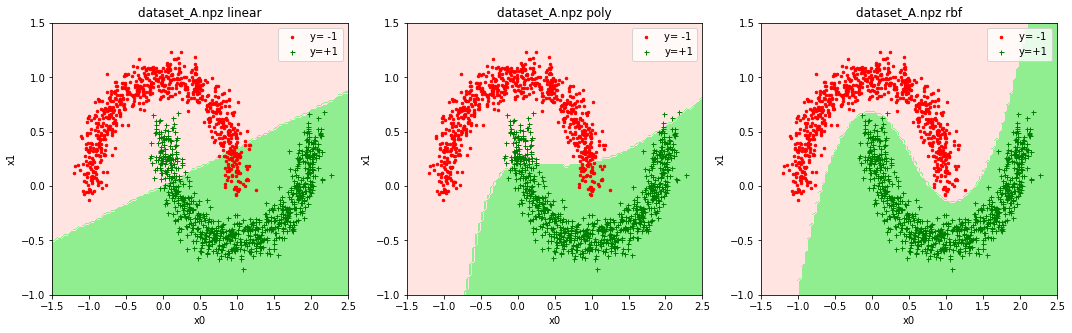

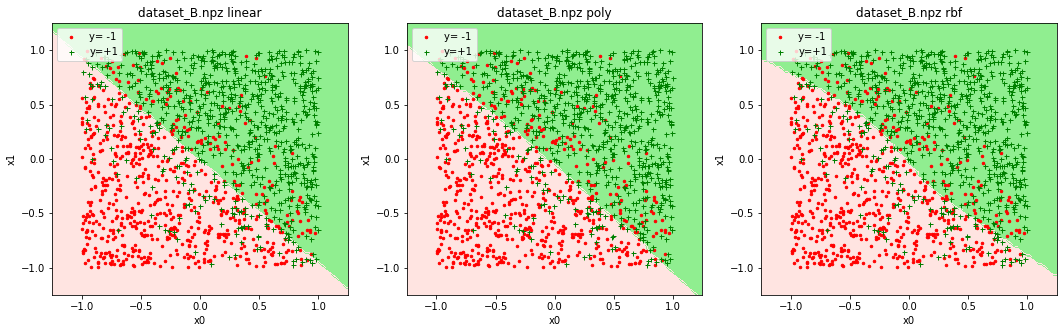

In [16]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6

def create_plot1(x1_scat,x2_scat,X,Y,Z):
    for id_ker, kernel in enumerate(kernel_types):
        plt.subplot(1,3,id_ker+1)
        plt.contourf(X,Y,Z[id_ker],colors=['mistyrose','lightgreen'])
        plt.plot(x1_scat[:,0], x1_scat[:,1],"r.",markersize=5, label='y= -1')
        plt.plot(x2_scat[:,0], x2_scat[:,1],"g+",markersize=5, label='y=+1')
        plt.title(filenames[id_data]+' '+kernel,size=12)
        plt.xlabel('x0')
        plt.ylabel('x1')
        plt.legend()

#Defining the 2D spaces to create plot        
x0space, x1space = [],[]

x0space.append(np.linspace(-1.5,2.5,100))
x1space.append(np.linspace(  -1,1.5,100))

x0space.append(np.linspace(-1.25,1.25,100))
x1space.append(np.linspace(-1.25,1.25,100))

X0_plt = np.zeros((2,100,100))
X1_plt = np.zeros((2,100,100))
X_to_pred = np.zeros((2,10000,2))
for i in range(2):
    X0_plt[i], X1_plt[i] = np.meshgrid(x0space[i], x1space[i])
    X_to_pred[i] = np.array([ [x0,x1] for x1 in x1space[i] for x0 in x0space[i]])
    

#Creating the plots
for id_data in range(2):
    X_train, Y_train, X_test, Y_test = read(filenames[id_data])
    X_val, Y_val, X_train2, Y_train2 = split_val_train(X_train, Y_train, ratio_val=0.3)
    
    Y_pred = [0,0,0]
    for id_ker, kernel in enumerate(kernel_types):

        ker_param_opt = opt_hyperparam[id_data, id_ker, 0]
        alpha = alpha_opt_data[id_data][id_ker]
        
        Y_pred[id_ker] = test_pred(alpha, X_train2, Y_train2, X_to_pred[id_data], kernel, ker_param_opt)

    Z = np.array([ Y.reshape(100,100) for Y in Y_pred])
    
    Xgym1, Xgyp1 = separate(X_train, Y_train)
    
    plt.figure(figsize = (18,5))
    create_plot1(Xgym1, Xgyp1, X0_plt[id_data], X1_plt[id_data], Z)
    plt.show()

# 2. SVM

Write code for learning SVM below. Also write code for choosing best hyperparameters for each kernel type. You may use sklearn.svm for this purpose. (use a part of training set as validation set)

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [7]:
# CodeWrite cell
# Write SVM classifier using SKlearn
# write only functions here

def get_clf(X_train,Y_train,X_test,Y_test,reg_param_array,kernel_param_array,kernel,train_frac):
    '''
    reg_param_array: array of regularisation parameters
    kernel_param_array: array of kernel parameteres
    kernel: linear, rbf or poly
    train_frac: Fraction of points from train dataset used for training.
    Rest will be used for validation, these do not overlap
    
    Returns:
    Best kernel and regularisation parameters
    Train and Test square zero-one errors for the chosen hyperparameters.
    Best learned classifier as a SVC object
    '''
    data = np.c_[X_train,Y_train]
    N = len(data)
    train_size = int(train_frac*N)
    
    temp = np.random.permutation(data)
    data_train = temp[0:train_size]
    data_validation = temp[train_size:]
    
    Xtrain = data_train[:,0:-1]
    Ytrain = data_train[:,-1]
    Xval = data_validation[:,0:-1]
    Yval = data_validation[:,-1]
    
    validation_err = []
    
    if kernel=='linear':
        for r in reg_param_array:
            clf = svm.SVC(kernel='linear',C=r)
            clf.fit(Xtrain,Ytrain)
            Yval_predict = clf.predict(Xval)
            del clf
            validation_err.append([r,np.mean(np.not_equal(Yval_predict,Yval))])
            
        validation_err = np.array(validation_err)
        optim_index = np.argmin(validation_err[:,-1])
        optim_reg_param = validation_err[optim_index,0]
        optim_kernel_param = None
        
        optim_clf = svm.SVC(kernel='linear',C=optim_reg_param)
        optim_clf.fit(X_train,Y_train)
        
    if kernel=='rbf':
        for r in reg_param_array:
            for k in kernel_param_array:
                clf = svm.SVC(kernel='rbf',gamma=k,C=r)
                clf.fit(Xtrain,Ytrain)
                Yval_predict = clf.predict(Xval)
                del clf
                validation_err.append([r,k,np.mean(np.not_equal(Yval_predict,Yval))])
        
        validation_err = np.array(validation_err)
        optim_index = np.argmin(validation_err[:,-1])
        optim_reg_param = validation_err[optim_index,0]
        optim_kernel_param = validation_err[optim_index,1]
        
        optim_clf = svm.SVC(kernel='rbf',gamma=optim_kernel_param,C=optim_reg_param)
        optim_clf.fit(X_train,Y_train)
    
    if kernel=='poly':
        for r in reg_param_array:
            for k in kernel_param_array:
                clf = svm.SVC(kernel='poly',degree=k,C=r)
                clf.fit(Xtrain,Ytrain)
                Yval_predict = clf.predict(Xval)
                del clf
                validation_err.append([r,k,np.mean(np.not_equal(Yval_predict,Yval))])
        
        validation_err = np.array(validation_err)
        optim_index = np.argmin(validation_err[:,-1])
        optim_reg_param = validation_err[optim_index,0]
        optim_kernel_param = validation_err[optim_index,1]
        
        optim_clf = svm.SVC(kernel='poly',degree=optim_kernel_param,C=optim_reg_param)
        optim_clf.fit(X_train,Y_train)
    
    Ytrain_pred = optim_clf.predict(Xtrain)
    Y_test_pred = optim_clf.predict(X_test)
        
    train_err = np.mean(np.not_equal(Ytrain_pred,Ytrain))
    test_err = np.mean(np.not_equal(Y_test_pred,Y_test))      

    return [optim_clf,train_err,test_err,optim_reg_param,optim_kernel_param]


In [8]:
# CodeWrite cell
# Write code here for doing validation (for kernel_param and regularisation_param)
# on a subset of the training set. 
# Also for generating the numbers that you report below.


reg_param_start = -4
reg_param_end = 2
reg_param = np.logspace(reg_param_start,reg_param_end,reg_param_end-reg_param_start+1)

rbf_param_start = -4
rbf_param_end = 4
rbf_param = np.logspace(rbf_param_start,rbf_param_end,rbf_param_end-rbf_param_start+1)

degree_max = 4
degree = np.arange(1,degree_max+1,1)

num_dataset = 4
dataset_char = ['A','B','C','D']
kernel = ['linear','rbf','poly']

train_frac = 0.70

output_list = [[[None for i in range(5)] for j in range(len(kernel))] for k in range(num_dataset)]

for n in range(num_dataset):
    print('============================================')
    print('Dataset '+dataset_char[n])
    print('\n')
    
    data = np.load('../../Data/dataset_'+dataset_char[n]+'.npz')
    #data = np.load('dataset_'+dataset_char[n]+'.npz')
    lst = data.files
    
    X_train = data[lst[0]]
    Y_train = data[lst[1]]
    X_test = data[lst[2]]
    Y_test = data[lst[3]]
    
    for algo in range(len(kernel)):
        if algo==1:
            kernel_param = rbf_param
        if algo==2:
            kernel_param = degree
        if algo==0:
            kernel_param = None
        
        print('=========================')
        kernel_type = kernel[algo]
        print(kernel_type)
        output_list[n][algo] = get_clf(X_train,Y_train,X_test,Y_test,reg_param,kernel_param,kernel_type,train_frac)
        print('Mean Train error is')
        print(output_list[n][algo][1])
        print('\n')
        print('Mean Test error is')
        print(output_list[n][algo][2])
        print('\n')
        print('Optimal regularisation parameter is')
        print(output_list[n][algo][3])
        print('\n')
        if output_list[n][algo][4]!=None:
            print('Optimal Kernel parameter is')
            print(output_list[n][algo][4])
            print('\n')

Dataset A


linear
Mean Train error is
0.1295238095238095


Mean Test error is
0.134


Optimal regularisation parameter is
1.0


rbf
Mean Train error is
0.0019047619047619048


Mean Test error is
0.002


Optimal regularisation parameter is
0.1


Optimal Kernel parameter is
10.0


poly
Mean Train error is
0.06285714285714286


Mean Test error is
0.082


Optimal regularisation parameter is
0.1


Optimal Kernel parameter is
3.0


Dataset B


linear
Mean Train error is
0.16666666666666666


Mean Test error is
0.188


Optimal regularisation parameter is
0.01


rbf
Mean Train error is
0.18285714285714286


Mean Test error is
0.202


Optimal regularisation parameter is
1.0


Optimal Kernel parameter is
0.1


poly
Mean Train error is
0.15047619047619049


Mean Test error is
0.198


Optimal regularisation parameter is
0.1


Optimal Kernel parameter is
1.0


Dataset C


linear
Mean Train error is
0.06571428571428571


Mean Test error is
0.1111111111111111


Optimal regularisation parameter is
0.


For training the SVM, we divided each training dataset into two subsets, with 70 percent(adjustable as a function argument, here found to be optimal) of dataset used for training and rest for validation. The points for each were chosen randomly and there is no overlap between these.

The range of hyperparameters was:

1. Regularisation: 1e-4 to 1e2, incremented 10 fold.
2. $\gamma$ for rbf kernel: 1e-4 to 1e4, incremented 10 fold.
3. Degrees for polynomial:1,2,3,4.


Some observations during training:
Dataset C and D have high number of features. For regularisation parameter greater than 100, it took a lot of time for training. But the train and test error only hovered about a value, within a range of less than 0.5%. So in the final version we have truncated the regularisation parameter range to only 1e-4 to 1e2.

We list the chosen hyperparameters for each dataset

|Attribute  | Linear    |  RBF     | Polynomial|
|-----------|-----------|----------|-----------|
|Dataset    |$\lambda$  |$\lambda$,$\gamma$|$\lambda$, Degree  |
|    A      |10.0|0.1, 10.0|10.0, 3|
|    B      |0.1|0.01, 1.0|0.01, 1|
|    C      |0.001|1.0, 0.001|1.0, 3|
|    D      |0.001|10.0, 0.0001|10.0, 1|

Observations:

1. Kernel for rbf: $e^{-\gamma||u-v||^2}$. $\gamma$ for rbf controls the sharpness of interpolation. Smaller values imply larger standard deviation so the interpolation around the value is flatter, i.e. if a linear support vector is a good fit, then when we apply rbf kernel, we should expect to get a smaller value of $\gamma$ since interpolation will be flatter around the point.
2. We have displayed the plots for dataset A and B in cell below this one. From this we can observe that a linear support vector for B should be a good fit. Indeed, the chosen hyperparameters for polynomial are degree 1 and for rbf the value of $\gamma$ is small. Since linear support graphically seems like a good fit, the chosen regularisation is also small. For A however, linear support is not a good fit and indeed the polynomial degree chosen is 3 while for rbf, $\gamma$ is large(sharper interpolation). For linear, regularisation parameter chosen is hence also large.
3. C and D are datasets with a large number of features. For D, the chosen degrees for polynomial are 1, and the chosen rbf kernel parameter $\gamma$ is small, indicating flatter interpolation. This indicates that the data for D is probably roughly linearly separable. Also since linear support is expected to be a good fit, the regularisation parameter chosen should be small, which is indeed what we get. For C, the optimal polynomial degree was 3, indicating that the data may not be linearly separable. Also, as we mention below, the errors for rbf and poly for this dataset were much lower than linear, again illustrating our case.

We now list the train and test zero one error for each dataset in a table. They are displayed side by side as a tuple for easy viewing and comparison.

|Attribute  | Linear    |  RBF     | Polynomial|
|-----------|-----------|----------|-----------|
|Dataset    |Train error, Test error |Train error, Test error|Train error, Test error|
|    A      |(0.1293,0.134)|(0.0013,0.002)|(0.06,0.082)|
|    B      |(0.1747,0.196)|(0.168, 0.188)|(0.17, 0.196)|
|    C      |(0.07267,0.0976)|(0.0, 0.023)|(0.0046,0.0404)|
|    D      |(0.045,0.065)|(0.0275,0.0710)|(0.085,0.0591)|

The train and test error are within a few percent of each other, which means our model has generalised well and we have partitioned the dataset in a good way into train and validation. From plots shown below,Dataset A seems to have a nonlinear support and we indeed get higher errors for linear than rbf and polynomial. Dataset B seems to have a linear support, and hence the observed errors for all kernels are in the same ballpark. C and D are high dimensional datasets. As described earlier, the hyperparamters for D point to existence of a good roughly linear separation. Here too we observe that the errors for all kernels are roughly in the same ballpark. For C however, the errors for linear were much higher than rest. Again iterating the fact that best polynomial degree was 3, these point to the actual support being nonlinear.

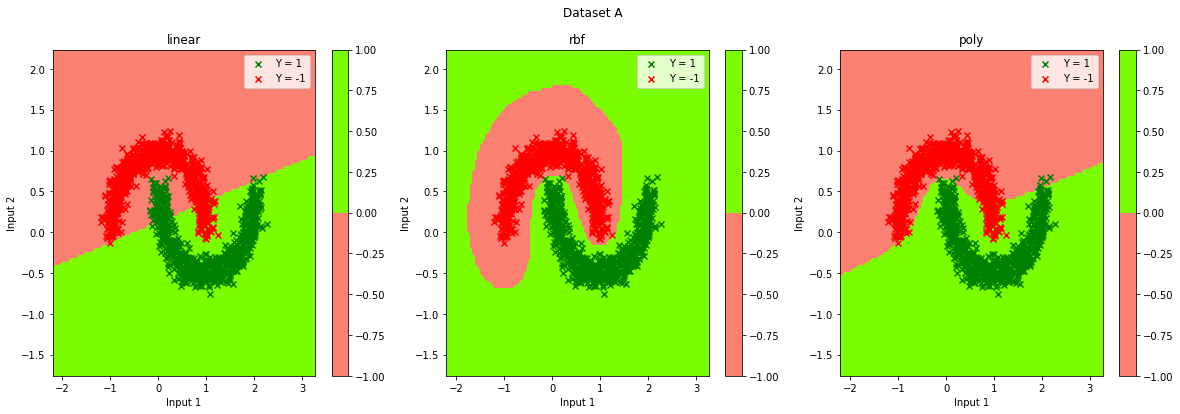

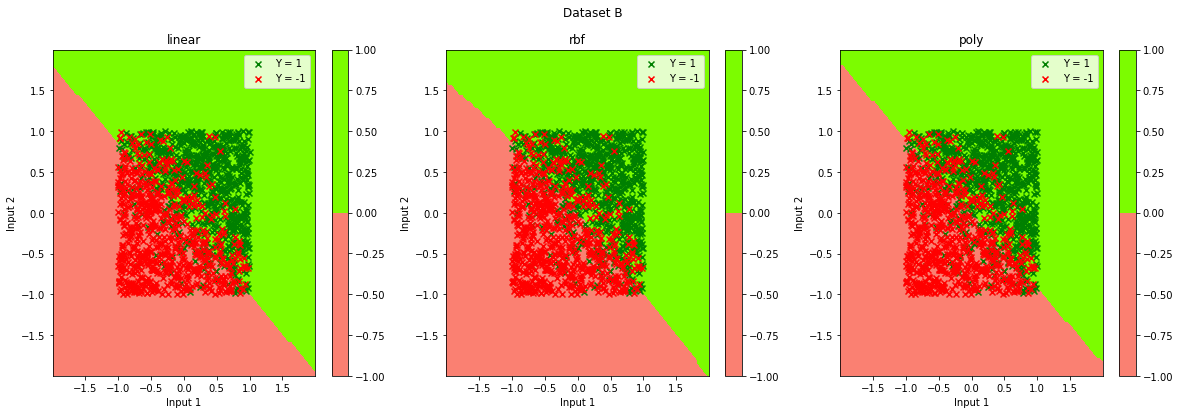

In [9]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6

def plot_clf_svm(clf_list,X_train,Y_train,charname):
    x1min = np.min(X_train[:,0])-1
    x1max = np.max(X_train[:,0])+1
    x2min = np.min(X_train[:,1])-1
    x2max = np.max(X_train[:,1])+1
    
    x1 = np.linspace(x1min,x1max,100)
    x2 = np.linspace(x2min,x2max,100)
    
    X1,X2 = np.meshgrid(x1,x2)
    
    X = np.c_[np.reshape(X1,(10000,1)),np.reshape(X2,(10000,1))]
    
    fig = plt.figure(figsize=(20,6))
    clf_name = ['linear','rbf','poly']
    
    for i in range(3):
        
        Y_temp = clf_list[i].predict(X)
        Y_temp = np.reshape(Y_temp,(100,100))
        
        fig.add_subplot(1,3,i+1)
        cmap = mpl.colors.ListedColormap(['salmon','lawngreen'])
        norm = mpl.colors.Normalize(vmin=-1,vmax=1)
        im = plt.contourf(X1,X2,Y_temp,cmap=cmap,norm=norm)
        
        ii = np.where(Y_train==1)
        plt.scatter(X_train[ii,0],X_train[ii,1],c='g',marker='x',label='Y = 1')
        ii = np.where(Y_train==-1)
        plt.scatter(X_train[ii,0],X_train[ii,1],c='r',marker='x',label='Y = -1')
        
        plt.xlabel('Input 1')
        plt.ylabel('Input 2')
        plt.title(clf_name[i])
        plt.legend()
        fig.colorbar(im)
        
    plt.suptitle('Dataset '+charname)    
    plt.show()
    
clf_list_a = [output_list[0][0][0],output_list[0][1][0],output_list[0][2][0]]
clf_list_b = [output_list[1][0][0],output_list[1][1][0],output_list[1][2][0]]

data = np.load('../../Data/dataset_A.npz')
#data = np.load('dataset_A.npz')
lst = data.files
X_train_a = data[lst[0]]
Y_train_a = data[lst[1]]

data = np.load('../../Data/dataset_B.npz')
#data = np.load('dataset_B.npz')
lst = data.files
X_train_b = data[lst[0]]
Y_train_b = data[lst[1]]

plot_clf_svm(clf_list_a,X_train_a,Y_train_a,'A')
plot_clf_svm(clf_list_b,X_train_b,Y_train_b,'B')


# 3. Decision Tree

Write code for learning decision tree below. Take as an argument a hyperparameter on what size node to stop splitting. Use a part of training set as validation set.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For all four data sets  report the best node size to stop splitting. Report the training and test zero-one error for those hyperparameters.

For datasets A and B, also illustrate the learned classifier. Do this in the last codeWrite cell for this question.

Important: Think about how you will represent a decision tree. (Possible soln: Store as a list of tuples containing node position, attribute to split, threshold, class to classifiy (if leaf node) )


In [12]:
# CodeWrite cell
# Write Decision tree classifier from scratch, 
# write only functions here (you may write extra functions here if you wish)

#Algorithm:
'''
For each node in tree, find: attribute, threshold, class
for which the desired criterion is the best
'''
def H(p):
    if p==0 or p==1:
        H = 0
    else:
        H = -p*np.log2(p)-(1-p)*np.log2(1-p)
    return H

def eval_criterion(X,Y,wt,attribute,threshold,criterion):
    iileft = np.where(X[:,attribute]<threshold)[0]
    iiright = np.where(X[:,attribute]>=threshold)[0]
    p_l = np.sum(wt[iileft])/np.sum(wt)
    p_r = np.sum(wt[iiright])/np.sum(wt)
        
    if len(iileft)>0 and len(iiright)>0:
        Yleft = Y[iileft]
        wtleft = wt[iileft]
        Yright = Y[iiright]
        wtright = wt[iiright]

        ii_l_1 = np.where(Yleft==1)[0]
        p_l_1 = np.sum(wtleft[ii_l_1])/np.sum(wtleft)
        
        ii_r_1 = np.where(Yright==1)[0]
        p_r_1 = np.sum(wtright[ii_r_1])/np.sum(wtright)
        
        if criterion=='accuracy':
            temp = p_l*(1-p_l_1)+p_r*p_r_1
            val = max(temp,1-temp)
        if criterion=='entropy':
            val = p_l*H(p_l_1)+p_r*H(p_r_1)
    
    if len(iileft)==0 and len(iiright)!=0:
        Yright = Y[iiright]
        wtright = wt[iiright]
        
        ii_r_1 = np.where(Yright==1)[0]
        p_r_1 = np.sum(wtright[ii_r_1])/np.sum(wtright)
        if criterion=='accuracy':
            val = max(p_r_1,1-p_r_1)
        if criterion=='entropy':
            val = H(p_r_1)
    if len(iileft)!=0 and len(iiright)==0:
        Yleft = Y[iileft]
        wtleft = wt[iileft]
        
        ii_l_1 = np.where(Yleft==1)[0]
        p_l_1 = np.sum(wtleft[ii_l_1])/np.sum(wtleft)
        
        if criterion=='accuracy':
            val = max(p_l_1,1-p_l_1)
        if criterion=='entropy':
            val = H(p_l_1)
    P_1 = np.sum(wt[np.where(Y==1)[0]])/np.sum(wt)
    
    if criterion=='accuracy':
        val_orig = max(P_1,1-P_1)
        if val<=val_orig:
            val = 0
    if criterion=='entropy':
        val_orig = H(P_1)
        if val>=val_orig:
            val = 1
    return val

def get_node_params(X,Y,wt,criterion):
    num_attribute = len(X[0])
    performance_array = []
    perf_2 = []
    for j in range(num_attribute):
        X_unique_att = np.unique(X[:,j])
        X_unique_att = np.sort(X_unique_att)
        
        num_val = len(X_unique_att)
        if num_val>=50:
            threshold = X_unique_att[int(0.02*num_val):-1:int(0.02*num_val)]
                   
        else:
            threshold = 0.5*(X_unique_att[0:-1]+X_unique_att[1:])
        ta = X_unique_att[-1]+1
        tb = X_unique_att[0]-1
        valuea = eval_criterion(X,Y,wt,j,ta,criterion)
        valueb = eval_criterion(X,Y,wt,j,tb,criterion)
        perf_2.append([j,ta,valuea])
        perf_2.append([j,tb,valueb])
        for t in threshold:
            value = eval_criterion(X,Y,wt,j,t,criterion)
            performance_array.append([j,t,value])
    
    if criterion =='accuracy':
        params = performance_array[np.argmax(np.array(performance_array)[:,-1])]
        params2 = perf_2[np.argmax(np.array(perf_2)[:,-1])]
        if params2[-1]>params[-1]:
            params = params2
    if criterion == 'entropy':
        params = performance_array[np.argmin(np.array(performance_array)[:,-1])]
        params2 = perf_2[np.argmin(np.array(perf_2)[:,-1])]
        if params2[-1]<params[-1]:
            params = params2
    return params[0],params[1],params[2]

def grow_tree(node_idx,X,Y,wt,criterion,max_nodes,max_depth,curr_depth,node_array):
    
    if len(node_array)<=max_nodes and curr_depth<max_depth:
        optim_att, optim_thr, optim_value = get_node_params(X,Y,wt,criterion)
        iileft = np.where(X[:,optim_att]<optim_thr)[0]
        Xleft = X[iileft]
        Yleft = Y[iileft]
        wtleft = wt[iileft]

        iiright = np.where(X[:,optim_att]>=optim_thr)[0]
        Xright = X[iiright]
        Yright = Y[iiright]
        wtright = wt[iiright]
        
        if ((optim_value==0 and criterion=='accuracy') or (optim_value==1 and criterion=='entropy')):
            P_1 = np.sum(wt[np.where(Y==1)[0]])/np.sum(wt)
            if P_1>0.5:
                temp = int(1)
            else:
                temp = int(-1)
        
            search_pointer = 'Node '+str(node_idx)
            res = [idx for idx, val in enumerate(tree) if (val[3]==search_pointer or val[4]==search_pointer)]
            ij = tree[res[0]].index(search_pointer)
            tree[res[0]][ij] = temp
            
        if ((optim_value>0 and criterion=='accuracy') or (optim_value<1 and criterion=='entropy')):
            
            if len(node_array)==max_nodes or curr_depth==max_depth-1:
                p_l_1 = np.sum(wtleft[np.where(Yleft==1)[0]])/np.sum(wtleft)
                if p_l_1>0.5:
                    left_node = int(1)
                    right_node = int(-1)
                else:
                    left_node = int(-1)
                    right_node = int(1)
                tree.append(['Node '+str(node_idx),optim_att,optim_thr,left_node,right_node])

            if len(node_array)<=max_nodes-1 and curr_depth<max_depth-1:
                if len(set(Yright))==1 and len(set(Yleft))==1:
                    left_node = int(Yleft[0])
                    right_node = int(Yright[0])
                    tree.append(['Node '+str(node_idx),optim_att,optim_thr,left_node,right_node])

                if len(set(Yright))==1 and len(set(Yleft))==2:
                    right_node = int(Yright[0])
                    left_node = node_array[-1]+1
                    node_array.append(left_node)
                    curr_depth+=1
                    tree.append(['Node '+str(node_idx),optim_att,optim_thr,'Node '+str(left_node),right_node])
                    grow_tree(left_node,Xleft,Yleft,wtleft,criterion,max_nodes,max_depth,curr_depth,node_array)

                if len(set(Yright))==2 and len(set(Yleft))==1:
                    left_node = int(Yleft[0])
                    right_node = node_array[-1]+1
                    node_array.append(right_node)
                    curr_depth+=1
                    tree.append(['Node '+str(node_idx),optim_att,optim_thr,left_node,'Node '+str(right_node)])
                    grow_tree(right_node,Xright,Yright,wtright,criterion,max_nodes,max_depth,curr_depth,node_array)

                if len(set(Yright))==0:
                    p_l_1 = np.sum(wtleft[np.where(Yleft==1)[0]])/np.sum(wtleft)
                    if p_l_1>0.5:
                        right_node = int(-1)
                        if p_l_1==1:
                            left_node = int(1)
                            tree.append(['Node '+str(node_idx),optim_att,optim_thr,left_node,right_node])
                        else:
                            left_node = node_array[-1]+1
                            node_array.append(left_node)
                            curr_depth+=1
                            tree.append(['Node '+str(node_idx),optim_att,optim_thr,'Node '+str(left_node),right_node])
                            grow_tree(left_node,Xleft,Yleft,wtleft,criterion,max_nodes,max_depth,curr_depth,node_array)
                    else:
                        if p_l_1==0:
                            left_node = int(-1)
                            tree.append(['Node '+str(node_idx),optim_att,optim_thr,left_node,right_node])

                        else:

                            right_node = int(1)
                            left_node = node_array[-1]+1
                            node_array.append(left_node)
                            curr_depth+=1
                            tree.append(['Node '+str(node_idx),optim_att,optim_thr,'Node '+str(left_node),right_node])
                            grow_tree(left_node,Xleft,Yleft,wtleft,criterion,max_nodes,max_depth,curr_depth,node_array)

                if len(set(Yleft))==0:
                    p_r_1 = np.sum(wtright[np.where(Yright==1)[0]])/np.sum(wtright)
                    if p_r_1>0.5:
                        left_node = int(-1)
                        if p_r_1==1:
                            right_node = int(1)
                            tree.append(['Node '+str(node_idx),optim_att,optim_thr,left_node,right_node])
                        else:
                            right_node = node_array[-1]+1
                            node_array.append(right_node)
                            curr_depth+=1
                            tree.append(['Node '+str(node_idx),optim_att,optim_thr,left_node,'Node '+str(right_node)])
                            grow_tree(right_node,Xright,Yright,wtright,criterion,max_nodes,max_depth,curr_depth,node_array)
                    else:
                        if p_r_1==0:
                            right_node = int(-1)
                            tree.append(['Node '+str(node_idx),optim_att,optim_thr,left_node,right_node])
                        else:

                            right_node = int(1)
                            left_node = node_array[-1]+1
                            node_array.append(left_node)
                            curr_depth+=1
                            tree.append(['Node '+str(node_idx),optim_att,optim_thr,'Node '+str(left_node),right_node])
                            grow_tree(left_node,Xleft,Yleft,wtleft,criterion,max_nodes,max_depth,curr_depth,node_array)

                if len(set(Yleft))==2 and len(set(Yright))==2:
                    if len(node_array)<=max_nodes-2:
                        left_node = node_array[-1]+1
                        right_node = node_array[-1]+2
                        node_array.append(left_node)
                        node_array.append(right_node)
                        curr_depth+=1
                        tree.append(['Node '+str(node_idx),optim_att,optim_thr,'Node '+str(left_node),'Node '+str(right_node)])
                        grow_tree(left_node,Xleft,Yleft,wtleft,criterion,max_nodes,max_depth,curr_depth,node_array)
                        grow_tree(right_node,Xright,Yright,wtright,criterion,max_nodes,max_depth,curr_depth,node_array)
                    else:
                        p_l_1 = np.sum(wtleft[np.where(Yleft==1)[0]])/np.sum(wtleft)
                        if p_l_1>0.5:
                            left_node = int(1)
                            right_node = int(-1)
                        else:
                            left_node = int(-1)
                            right_node = int(1)
                        tree.append(['Node '+str(node_idx),optim_att,optim_thr,left_node,right_node])

def train_decision_tree(X, Y, wt, num_nodes_stop, max_depth, criterion):
    '''
    Returns a decision tree trained on X and Y. 
    Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Returns a tree (In whatever format that you find appropriate)
    '''
    node_array = [0]
    node_init = 0
    curr_depth = 0
    
    if wt=='uniform':
        wt = np.ones(len(X))/len(X)
    
    global tree
    tree = []
    
    max_nodes = num_nodes_stop
    
    grow_tree(node_init,X,Y,wt,criterion,max_nodes,max_depth,curr_depth,node_array)
    return tree

def eval_decision_tree(tree, X):
    '''
    Takes in a tree, and a bunch of instances X and 
    returns the tree predicted values at those instances.
    '''
    Y = []
    for i in range(len(X)):
        #Initial:
        
        pointer = 'Node 0'
        
        while(type(pointer)!=int):
            res = [idx for idx, val in enumerate(tree) if val[0]==pointer]
            if X[i,tree[res[0]][1]]<tree[res[0]][2]:
                pointer = tree[res[0]][3]
            else:
                pointer = tree[res[0]][4]
        Y.append(pointer)
    return Y

In [11]:
# CodeWrite cell
# Write code here for doing validation to find the best hyperparameters (i.e. num_nodes_stop)
# Also Generate the numbers that you report below. 
# Repeat with criterion set to entropy also.
# CodeWrite cell
# Write code here for doing validation to find the best hyperparameters (i.e. num_nodes_stop)
# Also Generate the numbers that you report below. 
# Repeat with criterion set to entropy also.

def get_clf_tree(X_train,Y_train,X_test,Y_test,num_nodes_array,train_frac,criterion):
    
    data = np.c_[X_train,Y_train]
    N = len(data)
    train_size = int(train_frac*N)
    
    temp = np.random.permutation(data)
    data_train = temp[0:train_size]
    data_validation = temp[train_size:]
    
    Xtrain = data_train[:,0:-1]
    Ytrain = data_train[:,-1]
    Xval = data_validation[:,0:-1]
    Yval = data_validation[:,-1]
    
    validation_err = []
    
    
    for n_ in num_nodes_array:
        max_depth = int(np.log2(n_+1))
        tree = train_decision_tree(Xtrain, Ytrain, 'uniform', n_, max_depth,criterion)
        Yval_predict = eval_decision_tree(tree,Xval)
        err = np.mean(np.not_equal(Yval_predict,Yval))
        validation_err.append([n_,err])
                   
    validation_err = np.array(validation_err)
    optim_index = np.argmin(validation_err[:,-1])
    optim_num_nodes = int(validation_err[optim_index,0])
        
    optim_tree = train_decision_tree(Xtrain, Ytrain, 'uniform', optim_num_nodes, max_depth,criterion)
    
    Y_train_pred = eval_decision_tree(optim_tree,Xtrain)
    Y_test_pred = eval_decision_tree(optim_tree,X_test)
    
    train_err = np.mean(np.not_equal(Y_train_pred,Ytrain))
    test_err = np.mean(np.not_equal(Y_test_pred,Y_test))
    
    return [optim_tree,optim_num_nodes,train_err,test_err]

train_frac = 0.5

n = np.arange(1,11,1)
num_nodes_array = (2**n)-1

num_dataset = 4

char_list = ['A','B','C','D']

output_list_accuracy = [[[None] for i in range(4)] for j in range(num_dataset)]
output_list_entropy = [[[None] for i in range(4)] for j in range(num_dataset)]

for i in range(num_dataset):
    print('============================================')
    print('Dataset '+char_list[i])
    print('\n')
    
    data = np.load('../../Data/dataset_'+char_list[i]+'.npz')
    #data = np.load('dataset_'+char_list[i]+'.npz')
    lst = data.files
    X_train = data[lst[0]]
    Y_train = data[lst[1]]
    X_test = data[lst[2]]
    Y_test = data[lst[3]]
    
    output_list_accuracy[i] = get_clf_tree(X_train,Y_train,X_test,Y_test,num_nodes_array,train_frac,'accuracy')
    output_list_entropy[i] = get_clf_tree(X_train,Y_train,X_test,Y_test,num_nodes_array,train_frac,'entropy')
    
    print('==================')
    print('Optimum number of nodes stop for accuracy is')
    print(output_list_accuracy[i][1])
    print('\n')
    print('This corresponds to a depth of')
    print(int(np.log2(output_list_accuracy[i][1]+1)))
    print('\n')
    
    print('Train error is')
    print(output_list_accuracy[i][2])
    print('\n')
    
    print('Test error is')
    print(output_list_accuracy[i][3])
    print('\n')
    
    print('==================')
    print('Optimum number of nodes stop for entropy is')
    print(output_list_entropy[i][1])
    print('\n')
    print('This corresponds to a depth of')
    print(int(np.log2(output_list_entropy[i][1]+1)))
    print('\n')
    
    print('Train error is')
    print(output_list_entropy[i][2])
    print('\n')
    
    print('Test error is')
    print(output_list_entropy[i][3])
    print('\n')


Dataset A


Optimum number of nodes stop for accuracy is
7


This corresponds to a depth of
3


Train error is
0.09066666666666667


Test error is
0.104


Optimum number of nodes stop for entropy is
63


This corresponds to a depth of
6


Train error is
0.0


Test error is
0.024


Dataset B


Optimum number of nodes stop for accuracy is
31


This corresponds to a depth of
5


Train error is
0.176


Test error is
0.232


Optimum number of nodes stop for entropy is
3


This corresponds to a depth of
2


Train error is
0.228


Test error is
0.232


Dataset C


Optimum number of nodes stop for accuracy is
7


This corresponds to a depth of
3


Train error is
0.12


Test error is
0.13804713804713806


Optimum number of nodes stop for entropy is
127


This corresponds to a depth of
7


Train error is
0.0


Test error is
0.13468013468013468


Dataset D


Optimum number of nodes stop for accuracy is
3


This corresponds to a depth of
2


Train error is
0.045


Test error is
0.07100591715976332

Observations

First we report the chosen hyperparameters and error rates and make conclusions about this. Later we discuss and analyse the plots for accuracy criterion and point out some features of the approach. We split train dataset into train and validation(non overlapping) with a fraction of 0.5 in each(this gave better performance)

Chosen hyperparameters


|Dataset  | Max Nodes; accuracy criterion|Max Nodes; entropy criterion|
|---------|-------------------------------------|------------|
|A| 7| 63|
|B|3|511|
|C|7|511|
|D|1|15|

Error rates:

|Dataset  |Train error; accuracy|Test error; accuracy|Train error; entropy|Test error; entropy|
|---------|---------------------|--------------------|--------------------|-------------------|
|A|0.09067|0.102 | 0.0 |0.014|
|B|0.188|0.23|0.11067|0.27|
|C|0.1133|0.1380|0.0027|0.1348|
|D|0.08|0.106|0.0|0.059|

From the chosen hyperparameters, we can clearly see that the num_nodes_stop for accuracy is smaller than entropy. The training errors for entropy, unsurprisingly given more parameters, are very small compared to using accuracy(with the exception of B, where it is still smaller, but not that much; but dataset B has noise and orientation in conflict with that natural for decision trees as you can see from plots). Test errors for entropy are also smaller generally. We give the explanation for this and the plots together below(in short, in our greedy algorithm for decison tree, entropy is less vulnerable to getting stuck at local optima and is a smoother function). The test and train errors were also not very different from each other, a good indication of our ratio of split of validation and train.

We first note the challenge of decision tree: Constructing the optimal decision tree is NP-complete. To arrive at a decision tree from data deterministically in polynomial time, we use greedy algorithms, caring only about the immediate consequences of the node split. This sort of approach has the tendency to get stuck at local minima. Using accuracy as a split criterion makes us very vulnerable to this flaw compared to entropy. In dataset A and B, at an intermediate split, the optimal threshold for split becomes the extreme(min/max) value of the corresponding attribute. Other thresholds have lower performance at that node, but subsequent splits would have resulted in better optimal performance. This is the drawback of greedy algorithms. But using entropy as a criterion instead of accuracy results in better results with regards to the problem of getting stuck at the local minima. When we plotted for entropy(not shown below since extra plots were not asked), the resulting boundaries of the decision tree plotted on mesh were more closer to what you would expect from the training data.


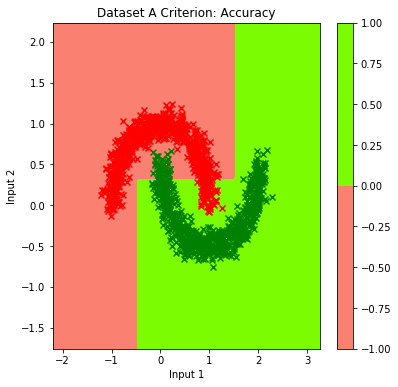

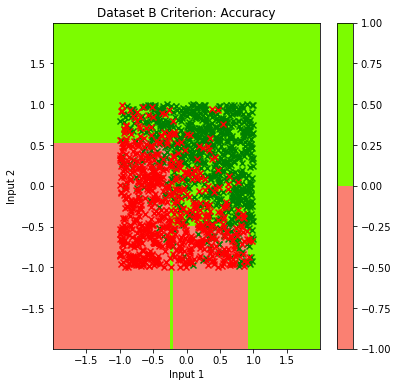

In [12]:
## Codewrite cell: Generate plots of learned decision tree classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots only required for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2

def visualise_tree(X_train,Y_train,tree,char_name):
    x1min = np.min(X_train[:,0])-1
    x1max = np.max(X_train[:,0])+1
    x2min = np.min(X_train[:,1])-1
    x2max = np.max(X_train[:,1])+1
    
    x1 = np.linspace(x1min,x1max,100)
    x2 = np.linspace(x2min,x2max,100)
    
    X1,X2 = np.meshgrid(x1,x2)
    
    X = np.c_[np.reshape(X1,(10000,1)),np.reshape(X2,(10000,1))]
    
    fig = plt.figure(figsize=(6,6))
    
    Y_pred = eval_decision_tree(tree, X)
    Y_pred = np.reshape(Y_pred,(100,100))
        
    fig.add_subplot(1,1,1)
    cmap = mpl.colors.ListedColormap(['salmon','lawngreen'])
    norm = mpl.colors.Normalize(vmin=-1,vmax=1)
    im = plt.contourf(X1,X2,Y_pred,cmap=cmap,norm=norm)
        
    ii = np.where(Y_train==1)
    plt.scatter(X_train[ii,0],X_train[ii,1],c='g',marker='x',label='Y = 1')
    ii = np.where(Y_train==-1)
    plt.scatter(X_train[ii,0],X_train[ii,1],c='r',marker='x',label='Y = -1')
        
    plt.xlabel('Input 1')
    plt.ylabel('Input 2')
    plt.title('Dataset '+char_name+' Criterion: Accuracy')
    fig.colorbar(im)
    plt.show()

data = np.load('../../Data/dataset_A.npz')
#data = np.load('dataset_A.npz')
lst = data.files
X_train = data[lst[0]]
Y_train = data[lst[1]]
tree = output_list_accuracy[0][0]
visualise_tree(X_train,Y_train,tree,'A')

data = np.load('../../Data/dataset_B.npz')
#data = np.load('dataset_B.npz')
lst = data.files
X_train = data[lst[0]]
Y_train = data[lst[1]]
tree = output_list_accuracy[1][0]
visualise_tree(X_train,Y_train,tree,'B')


# 4 Random Forest classifier

Write code for learning RandomForests below. Fix the following hyper parameters: (Fraction of data to learn tree=0.5, Fraction of number of features chosen in each node=0.5, num_nodes_stop=1).  Choose the number of trees to add in the forest by using a validation set. You may use a slightly modified version of the decision tree code you had written earlier.

Write code for running in the cell after the nest. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  report the best number of trees found. Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [13]:
# CodeWrite cell
# Write Random Forest classifier.

def read_rf(filename):
    data = np.load('../../Data/'+filename)
    lst = data.files
    
    X_train = data[lst[0]]
    Y_train = data[lst[1]]
    X_test  = data[lst[2]]
    Y_test  = data[lst[3]]
    
    return X_train, Y_train, X_test, Y_test


def separate_rf(X,Y):
    X_g_y_m1 = [] #shall contain X for which Y = -1
    X_g_y_p1 = [] #shall contain X for which Y = +1
    
    for i in range(Y.shape[0]):
        if(Y[i]==-1):
            X_g_y_m1.append(X[i])
        else:
            X_g_y_p1.append(X[i])
    
    return np.array(X_g_y_m1), np.array(X_g_y_p1)


def split_val_train_rf(X_train, Y_train, ratio_val=0.2):
    X_train2 = []
    Y_train2 = []
    
    X_val = []
    Y_val = []
    
    factor = int(1/ratio_val)
    for i in range(len(X_train)):
        if i%factor == 0:
            X_val.append(X_train[i])
            Y_val.append(Y_train[i])
        else:
            X_train2.append(X_train[i])
            Y_train2.append(Y_train[i])
    
    return np.array(X_val), np.array(Y_val), np.array(X_train2), np.array(Y_train2) 


def zero_one_error_bw_pred_actual_rf(Y_pred, Y_actual):
    correct = np.count_nonzero(Y_pred == Y_actual)
    return 1 - (correct/len(Y_pred))


def train_random_forest(X, Y, num_trees=10, num_nodes_stop=1, 
                        criterion='accuracy', a=0.5, b=0.5):
    """ Returns a random forest trained on X and Y. 
    Trains num_trees.
    Stops splitting nodes in each tree when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Fraction of data used per tree = a
    Fraction of features used in each node = b
    Returns a random forest (In whatever format that you find appropriate)
    """

    (n, d) = np.shape(X)
    max_depth_rf = np.log2(num_nodes_stop+1) + 10
    
    forest = []

    rand_genrtr = np.random.default_rng()

    for i in range(int(num_trees)):

        bag_data_pts = rand_genrtr.choice(n, size = int(a*n), replace = False)
        bag_attr     = rand_genrtr.choice(d, size = int(b*d), replace = False)
        
        X_train = X[bag_data_pts][:,bag_attr]
        Y_train = Y[bag_data_pts]
        
        tree = train_decision_tree(X_train, Y_train, 'uniform', num_nodes_stop, max_depth_rf, criterion)
        
        forest.append((bag_attr, tree))
    
    return forest



def eval_random_forest(random_forest, test_X):
    """ Takes in a  random forest object (hhowever you want to store it), and a bunch of instances X and 
    returns the tree predicted values at those instances."""
    
    n = len(test_X)
    num_trees = len(random_forest)
    
    Y_pred_mat = np.zeros( (num_trees, n) )
    
    for id_tree in range(num_trees):
        bag_attr = random_forest[id_tree][0]
        tree     = random_forest[id_tree][1]
        Y_pred_mat[id_tree] = eval_decision_tree(tree, test_X[:,bag_attr])
        
    Y_pred_frac = np.mean(Y_pred_mat, axis=0)
    Y_pred_pm1 = np.zeros(n)
    Y_pred_pm1[ Y_pred_frac >  0] =  1
    Y_pred_pm1[ Y_pred_frac <= 0] = -1
    
    return Y_pred_pm1

In [33]:
# CodeWrite cell
# Write code for choosing the best hyperparameters (num_trees, num_nodes_stop)
# Write code here for generating the numbers that you report below.
# Repeat above for criterion set to entropy also.

filenames = ['dataset_A.npz','dataset_B.npz','dataset_C.npz','dataset_D.npz']

num_trees_arr = np.unique(np.logspace(0, 12, 7, base=2).astype(int))
criterion_lst = ['accuracy', 'entropy']
err_val_rand_forest = np.zeros((4,2,len(num_trees_arr)))
err_train_rand_forest = np.zeros((4,2,len(num_trees_arr)))

num_trees_opt = np.zeros((4,2))
forest_opt = [[0,0], [0,0], [0,0], [0,0]]

for id_data in range(len(filenames)):
    
    X_train, Y_train, X_test, Y_test = read_rf(filenames[id_data])
    X_val, Y_val, X_train2, Y_train2 = split_val_train_rf(X_train, Y_train, ratio_val=0.3)
    
    print('=========================================================================')
    print(filenames[id_data])
    
    if id_data == 1:
        a_val = 0.1
        num_nodes_stop = 1
        
    else:
        a_val = 0.5
        num_nodes_stop = 7
    
    for i in range(len(criterion_lst)):
        
        print('Criterion = ', criterion_lst[i])
        
        for id_num_tree in range(len(num_trees_arr)):
            random_forest = train_random_forest(X_train2, Y_train2, num_trees_arr[id_num_tree], num_nodes_stop, criterion_lst[i], a_val, b=0.5)
            Y_pred_val = eval_random_forest(random_forest, X_val)
            err_val_rand_forest[ id_data, i, id_num_tree] = zero_one_error_bw_pred_actual_rf(Y_pred_val, Y_val)
            
            if id_num_tree == 0:
                num_trees_opt[id_data, i] = num_trees_arr[id_num_tree]
                forest_opt[id_data][i] = random_forest
                
            elif err_val_rand_forest[ id_data, i, id_num_tree] < min(err_val_rand_forest[ id_data, i, : id_num_tree]):
                num_trees_opt[id_data, i] = num_trees_arr[id_num_tree]
                forest_opt[id_data][i] = random_forest
        
        Y_pred_train2 = eval_random_forest(forest_opt[id_data][i], X_train2)
        print('Mean Train error is = ', zero_one_error_bw_pred_actual_rf(Y_pred_train2, Y_train2), '\n')
        
        Y_pred_test = eval_random_forest(forest_opt[id_data][i], X_test)                               
        print('Mean Test error is = ', zero_one_error_bw_pred_actual_rf(Y_pred_test, Y_test), '\n')
        
        print('Optimal number of trees is ', num_trees_opt[id_data, i])
        
        print('============================================')
    print('\n\n\n')

dataset_A.npz
Criterion =  accuracy
Mean Train error is =  0.07999999999999996 

Mean Test error is =  0.10999999999999999 

Optimal number of trees is  64.0
Criterion =  entropy
Mean Train error is =  0.137 

Mean Test error is =  0.17200000000000004 

Optimal number of trees is  256.0




dataset_B.npz
Criterion =  accuracy
Mean Train error is =  0.18500000000000005 

Mean Test error is =  0.20599999999999996 

Optimal number of trees is  256.0
Criterion =  entropy
Mean Train error is =  0.17600000000000005 

Mean Test error is =  0.20199999999999996 

Optimal number of trees is  64.0




dataset_C.npz
Criterion =  accuracy
Mean Train error is =  0.07899999999999996 

Mean Test error is =  0.12794612794612792 

Optimal number of trees is  1024.0
Criterion =  entropy
Mean Train error is =  0.051000000000000045 

Mean Test error is =  0.08754208754208759 

Optimal number of trees is  256.0




dataset_D.npz
Criterion =  accuracy
Mean Train error is =  0.015037593984962405 

Mean Test e

TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).

## Hyperparameters apart from number of trees

For dataset B, the maximum number of nodes was taken to be 1, and the fraction of data chosen for each tree was, a = 0.1.

For datasets A, C, D, the maximum number of nodes was taken to 7 (a bit greater than 1) and the fraction of data chosen for each tree was, a = 0.5.

We didn't want to increase the number of nodes too much so that each tree remains a weak classifier, because a random forest performs better when the variance is higher. In the table for validation error vs number of trees, looking at the num trees = 1 column, we can see that the tree does not perform very well for datasets other than D, hence it is a weak classifier. (For dataset D, for num_nodes_stop = 1, the validation error for num_trees = 1 was not very worse (0.08), but the least error for any number of trees was 0.06, so we increased num_nodes_stop to get a better accuracy)

For dataset B, random forest actually performd better for a weak classifier with a = 0.1 as compared to a = 0.5.


## Validation error vs number of trees
The validation error for the four data sets for different number of trees for the two criteria (accuracy and entropy) is as follows:

|           	| Criterion\Num   trees: 	| 1        	| 4        	| 16       	| 64       	| 256      	| 1024     	| 4096     	|
|-----------	|------------------------	|----------	|----------	|----------	|----------	|----------	|----------	|----------	|
| **Dataset A** 	| Accuracy               	| 0.184    	| 0.192    	| 0.184    	| **0.104**    	| 0.11     	| 0.106    	| 0.152    	|
|           	| Entropy                	| 0.47     	| 0.456    	| 0.272    	| 0.226    	| **0.16**     	| 0.19     	| 0.178    	|
|           	|                        	|          	|          	|          	|          	|          	|          	|          	|
| **Dataset B** 	| Accuracy               	| 0.276    	| 0.278    	| 0.272    	| 0.212    	| **0.2**      	| 0.234    	| 0.228    	|
|           	| Entropy                	| 0.278    	| 0.324    	| 0.286    	| **0.18**     	| 0.188    	| 0.194    	| 0.19     	|
|           	|                        	|          	|          	|          	|          	|          	|          	|          	|
| **Dataset C** 	| Accuracy               	| 0.126    	| 0.136    	| 0.114    	| 0.094    	| 0.102    	| **0.086**    	| 0.09     	|
|           	| Entropy                	| 0.702    	| 0.154    	| 0.09     	| 0.094    	| **0.072**    	| 0.074    	| 0.074    	|
|           	|                        	|          	|          	|          	|          	|          	|          	|          	|
| **Dataset D** 	| Accuracy               	| 0.067164 	| 0.08209  	| 0.044776 	| **0.037313** 	| 0.037313 	| 0.044776 	| 0.044776 	|
|           	| Entropy                	| 0.074627 	| 0.044776 	| 0.037313 	| **0.029851** 	| 0.037313 	| 0.029851 	| 0.029851 	|

## Observations:

- The validation error decreases considerably as num_trees increases from 1, especially for A, entropy (0.47 $\rightarrow$ 0.16) and C, entropy (0.7 $\rightarrow$ 0.07)
- After a particular number of trees, the error doesn't change much (and in a few cases the error is even non insignificantly higher for higher num_trees as compared to optimum).

## Otimum number of trees; train, test error
The optimum number of trees in the forest and the train and test errors for the four datasets for the two criteria (accuracy and entropy) are as follows:

### Dataset A
| Criterion 	| Num trees 	| Train Error 	| Test error 	|
|-----------	|-----------	|-------------	|------------	|
| **Accuracy**  	| 64        	| 0.08        	| 0.11       	|
| **Entropy**   	| 256       	| 0.137       	| 0.17       	|

### Dataset B
| Criterion 	| Num trees 	| Train Error 	| Test error 	|
|-----------	|-----------	|-------------	|------------	|
| **Accuracy**  	| 256       	| 0.185       	| 0.206      	|
| **Entropy**   	| 64        	| 0.176       	| 0.202      	|

### Dataset C
| Criterion 	| Num trees 	| Train Error 	| Test error 	|
|-----------	|-----------	|-------------	|------------	|
| **Accuracy**  	| 1024      	| 0.079       	| 0.128      	|
| **Entropy**   	| 256       	| 0.051       	| 0.088      	|

### Dataset D
| Criterion 	| Num trees 	| Train Error 	| Test error 	|
|-----------	|-----------	|-------------	|------------	|
| **Accuracy**  	| 64        	| 0.015       	| 0.047      	|
| **Entropy**   	| 64        	| 0.004       	| 0.024      	|


## Obervations

- We can see that random forest gives pretty low error for all the datasets. (Error of ~0.2 is fine for dataset B because the data is very noisy, other methods also gave results ~0.2).
- Comparing the test errors to the validation errors (for the same (optimum) hyperparameters) we observe that they lie within a 0.01 range of each other (except for C, accuracy - 0.04), hence the validation set is a pretty good estimate for a test set.

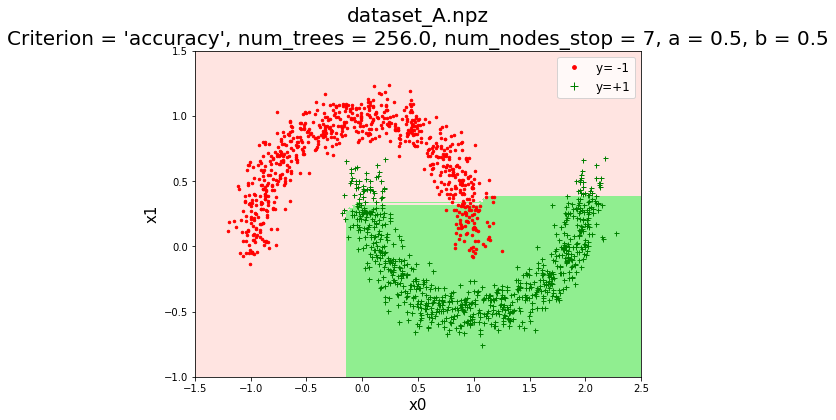

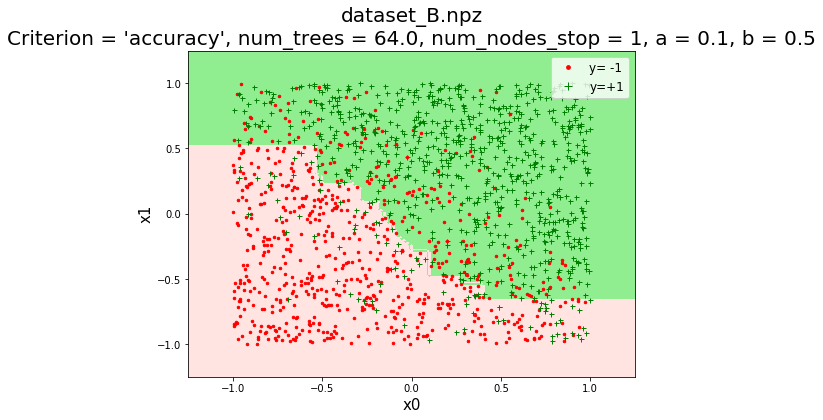

In [17]:
## Codewrite cell: Generate plots of learned Random Forest classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots required only for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 



def create_plot_rf(x_m1_scat,x_p1_scat,X,Y,Z):
    plt.contourf(X,Y,Z,colors=['mistyrose','lightgreen'])
    plt.plot(x_m1_scat[:,0], x_m1_scat[:,1],"r.",markersize=5, label='y= -1')
    plt.plot(x_p1_scat[:,0], x_p1_scat[:,1],"g+",markersize=5, label='y=+1')
    plt.title(filenames[id_data]+'\nCriterion = \'accuracy\', num_trees = '+str(num_trees_opt[id_data][0])
              +', num_nodes_stop = '+str(num_nodes_stop)+', a = '+str(a_val)+', b = 0.5',size=20)
    plt.xlabel('x0',size=15)
    plt.ylabel('x1',size=15)
    plt.legend(loc=1,markerscale=1.5,fontsize=12)

    
#Defining the 2D spaces to create plot        
x0space, x1space = [],[]

x0space.append(np.linspace(-1.5,2.5,100))
x1space.append(np.linspace(  -1,1.5,100))

x0space.append(np.linspace(-1.25,1.25,100))
x1space.append(np.linspace(-1.25,1.25,100))

X0_plt = np.zeros((2,100,100))
X1_plt = np.zeros((2,100,100))
X_to_pred = np.zeros((2,10000,2))
for i in range(2):
    X0_plt[i], X1_plt[i] = np.meshgrid(x0space[i], x1space[i])
    X_to_pred[i] = np.array([ [x0,x1] for x1 in x1space[i] for x0 in x0space[i]])
    
    
    
    
#Creating the plots
for id_data in range(len(filenames)-2):
    X_train, Y_train, X_test, Y_test = read_rf(filenames[id_data])
    
    if id_data == 0:
        num_nodes_stop = 7
        a_val = 0.5
    else:
        num_nodes_stop = 1
        a_val = 0.1
    
    random_forest = forest_opt[id_data][0]  
    Y_pred = eval_random_forest(random_forest, X_to_pred[id_data])

    Xgym1, Xgyp1 = separate_rf(X_train, Y_train)
    Z = Y_pred.reshape(100,100)
    
    
    plt.figure(figsize = (8,6))
    create_plot_rf(Xgym1, Xgyp1, X0_plt[id_data], X1_plt[id_data], Z)
    plt.show()
    
    

# 5 AdaBoost

Write code for learning using AdaBoost below. Use 3 different weak learners below. (You may reuse code written above)

1. 1 node decision tree 
2. Decision tree of fixed depth = 3 (Root, child, grand child)
3. Decision tree of fixed depth = 7 (Root, child, grand child, ..., great^4 grand child)

Run for 50 iterations. You may use the accuracy split criterion for all the three weak learners.

Write code for running in the next cell. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  plot the train and test accuracy vs iterations. A total of 12 plots is expected. 4 datasets * 3 weak learners. Each plot should contain two curves, train and test error.  

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each weak learner setting. A total of 6 contourf style plots are expected here. Do this in the last codeWrite cell for this question.

Summarise your observations in the last textwrite cell.

In [17]:
# Codewrite cell
# Write code to run here (no plotting)
# Codewrite cell
# Write code to run here (no plotting)
def adaboost_weak_tree(X_train,Y_train,X_test,Y_test,max_nodes,max_depth,num_iterations,criterion):
    weak_learners = []
    weight = [np.ones(len(X_train))/(len(X_train))]
    gamma = []
    beta = []
    l = []
    train_err = []
    test_err = []
    wt_sum_train = 0
    wt_sum_test = 0
    wt_sum_train2 = 0
    
    
    for i in range(num_iterations):
        temp_tree = train_decision_tree(X_train, Y_train, weight[i], max_nodes, max_depth, criterion)
        Y_pred_train = np.array(eval_decision_tree(temp_tree,X_train))
        l_ = np.not_equal(Y_pred_train,Y_train)
        
        gamma_ = 0.5-(np.sum(weight[i]*l_))/np.sum(weight[i])
        if gamma_>0.4999:
            break
        gamma.append(gamma_)
        
        beta_ = (gamma_+0.5)/(0.5-gamma_)
        beta.append(beta_)
        l.append(l_)
        weight.append(weight[i]*(beta_**(l_)))
        
        weak_learners.append(temp_tree)
        
        Y_pred_test = eval_decision_tree(temp_tree,X_test)
        
        wt_sum_train+=np.log(beta_)*np.array(Y_pred_train)
        wt_sum_test+=np.log(beta_)*np.array(Y_pred_test)
        
        h_T_train = np.sign(wt_sum_train)
        h_T_test = np.sign(wt_sum_test)
        
        temp_train_err = np.mean(np.not_equal(Y_train,h_T_train))
        temp_test_err = np.mean(np.not_equal(Y_test,h_T_test))
        
        train_err.append(temp_train_err)
        test_err.append(temp_test_err)
    
    return train_err, test_err, beta, weak_learners

num_datasets = 4
num_adaboost = 3
char_list = ['A','B','C','D']
num_iterations = 50

train_err = np.zeros((num_datasets,num_adaboost,num_iterations))
test_err = np.zeros((num_datasets,num_adaboost,num_iterations))
beta = np.zeros((num_datasets,num_adaboost,num_iterations))

max_depth = [1,2,3] # We count node+leaf to have depth 1
max_nodes = 50 #Not active here, so we set it to be greater than 2**depth -1

weak_learners = [[[[None] for i in range(num_iterations)] for j in range(num_adaboost)] for k in range(num_datasets)]
criterion = 'accuracy'

for i in range(num_datasets):
    data = np.load('../../Data/dataset_'+char_list[i]+'.npz')
    #data = np.load('dataset_'+char_list[i]+'.npz')
    lst = data.files
    X_train = data[lst[0]]
    Y_train = data[lst[1]]
    X_test = data[lst[2]]
    Y_test = data[lst[3]]
    
    for j in range(num_adaboost):
        train_err[i,j], test_err[i,j], beta[i,j], weak_learners[i][j] = adaboost_weak_tree(X_train,Y_train,X_test,Y_test,max_nodes,max_depth[j],num_iterations,'accuracy')

C:\Users\tapan\anaconda3\lib\site-packages\ipykernel_launcher.py:254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


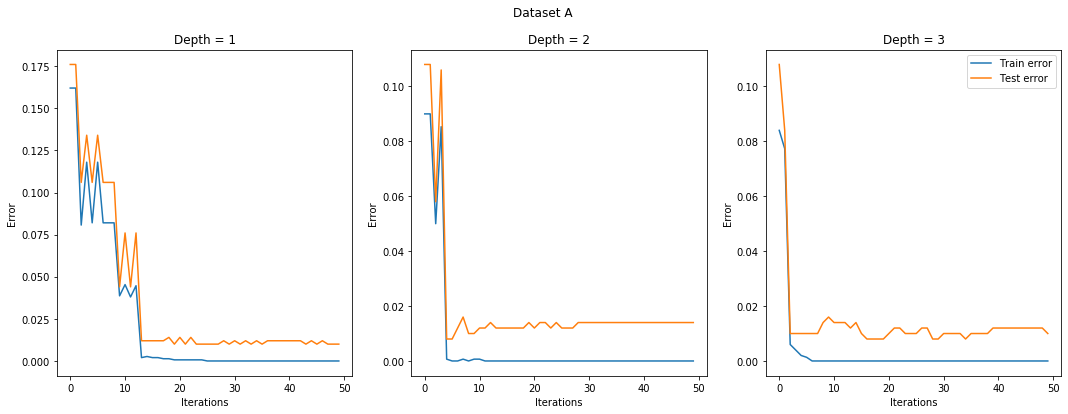

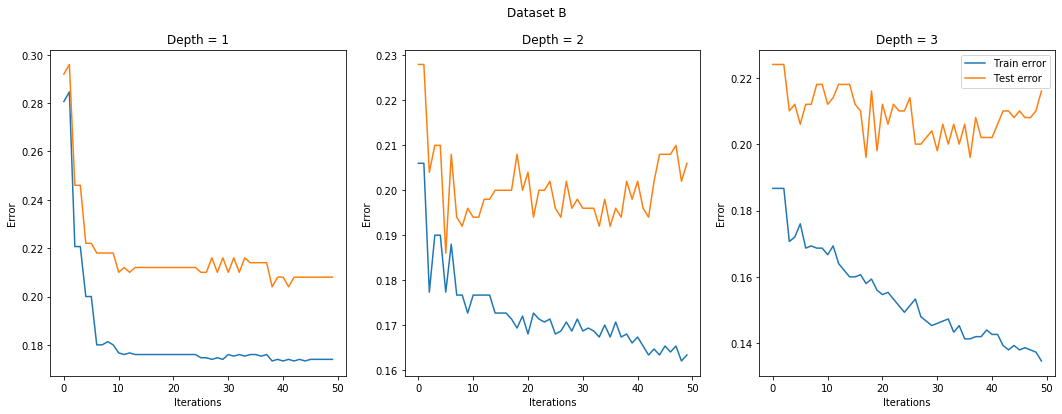

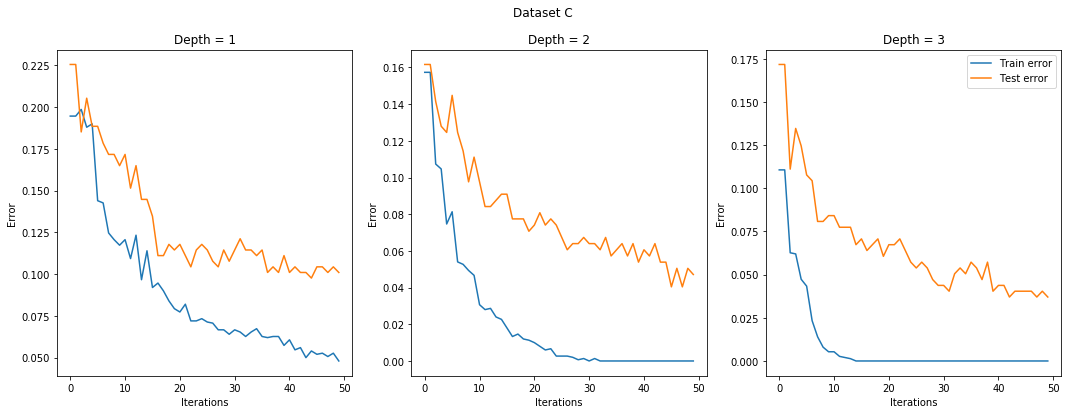

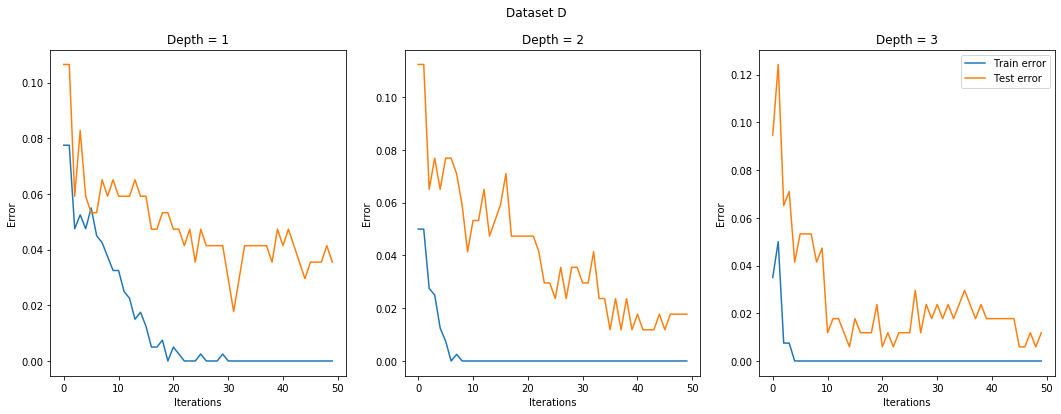

In [18]:
# Codewrite cell 
# Plots for iteration vs error here

for i in range(num_datasets):
    fig, ax = plt.subplots(1,3,figsize=(18,6))
    for j in range(num_adaboost):
        
        ax[j].plot(train_err[i,j],label='Train error')
        ax[j].plot(test_err[i,j],label='Test error')
        ax[j].set_xlabel('Iterations')
        ax[j].set_ylabel('Error')
        ax[j].set_title('Depth = '+str(max_depth[j]))
    plt.legend()
    plt.suptitle('Dataset '+char_list[i])
    plt.show()

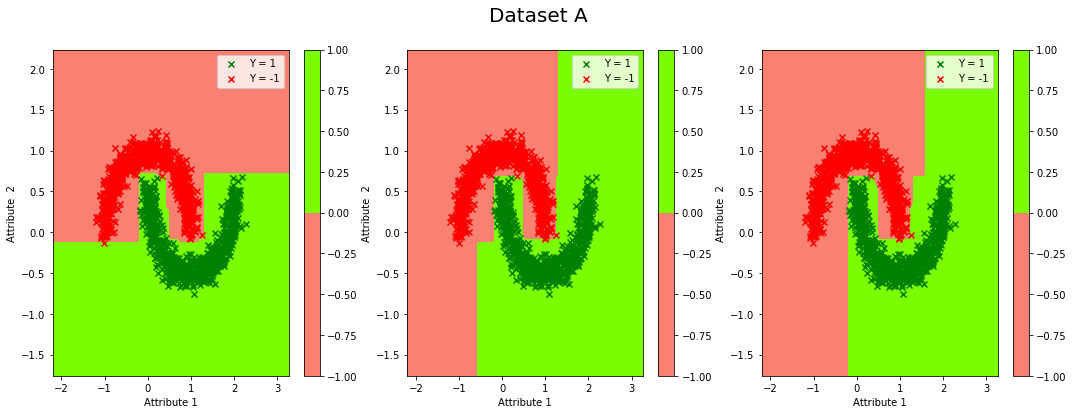

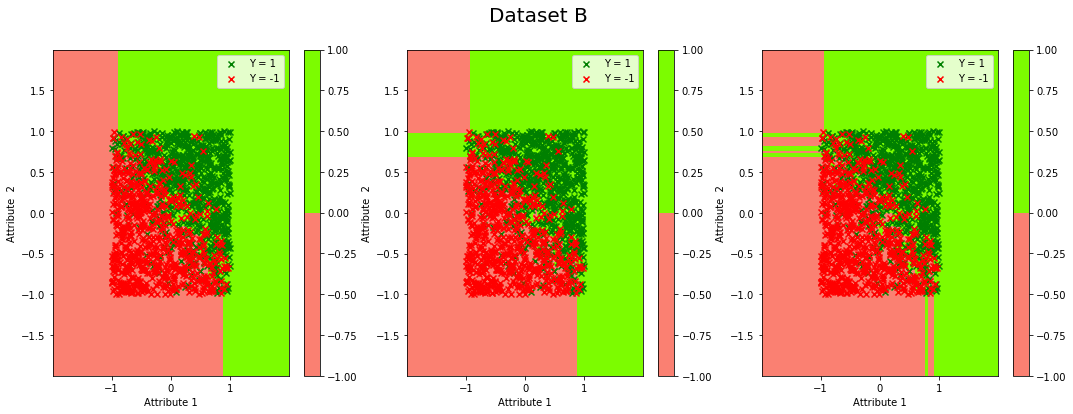

In [19]:
# Codewrite cell 
# Plots for illustrating the classifier here
num_datasets = 2
for i in range(num_datasets):
    data = np.load('../../Data/dataset_'+char_list[i]+'.npz')
    #data = np.load('dataset_'+char_list[i]+'.npz')
    lst = data.files
    X_train = data[lst[0]]
    Y_train = data[lst[1]]
    X_test = data[lst[2]]
    Y_test = data[lst[3]]
    
    x1min = np.min(X_train[:,0])-1
    x1max = np.max(X_train[:,0])+1
    x2min = np.min(X_train[:,1])-1
    x2max = np.max(X_train[:,1])+1
    
    x1 = np.linspace(x1min,x1max,100)
    x2 = np.linspace(x2min,x2max,100)
    
    X1,X2 = np.meshgrid(x1,x2)
    
    X = np.c_[np.reshape(X1,(10000,1)),np.reshape(X2,(10000,1))]
    
    
    fig = plt.figure(figsize=(18,6))
    for j in range(num_adaboost):
        wt_sum = 0
        for k in range(num_iterations):
            wt_sum+=np.log(beta[i,j,k])*np.array(eval_decision_tree(weak_learners[i][j][k],X))
        
        fig.add_subplot(1,3,j+1)
        Y = np.sign(wt_sum)
        Y = np.reshape(Y,(100,100))
        
        cmap = mpl.colors.ListedColormap(['salmon','lawngreen'])
        norm = mpl.colors.Normalize(vmin=-1,vmax=1)
        im = plt.contourf(X1,X2,Y,cmap=cmap,norm=norm)
        
        ii = np.where(Y_train==1)
        plt.scatter(X_train[ii,0],X_train[ii,1],c='g',marker='x',label='Y = 1')
        ii = np.where(Y_train==-1)
        plt.scatter(X_train[ii,0],X_train[ii,1],c='r',marker='x',label='Y = -1')
        plt.legend()
        fig.colorbar(im)
        plt.xlabel('Attribute 1')
        plt.ylabel('Attribute  2')
    
    plt.suptitle('Dataset '+char_list[i],size=20)
    plt.show()

Analysis for error plots:

We observe that in all plots, with the exception of B(which is very noisy data) for training error for adaboost with different tree depths, the train error goes to exactly zero. For dataset B, not only is the data noisy, but the optimal support is a line at 135 degrees, and hence using x and y axis attributes to split requires greater depth to succeed. However, the decrease in error by boosting is still evident here. We also observe that error drops less rapidly if the weak learner is very weak. Also not only are training errors lower than if you used single decision trees, but so are test errors, for all datasets. This also emphasises power of boosting over single classifiers.

Analysis for plots for value over mesh:

After plotting the final adaboost for dataset A over the meshgrid it is evident that out model has learnt a good separation between positive and negative points. Note that all of our adaboost was done using the accuracy criterion. In our discussion on decision trees we learnt that using greedy algorithms, particularly with accuracy criterion, may result in suboptimal performace due to being stuck at local optima. By using boosting, this problem was overcome and the decision boundaries in the plot look more natural for the data. 

For dataset B, as explained earlier, the nature of data(noise and orientation) make it hard for decision trees to achieve a good fit. But here too from the plots we can see that the adaboost has learnt the boundaries reasonably well and much better than the plots for single tree.